In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from scipy import sparse 
from importlib import reload
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
import numbers
from multiprocessing import Pool
import functools
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings(action='once')

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [3]:
#cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
#cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
#tracking_files = ['/volumes/My_Passport/dlc_analysis/behavcamvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [6]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [7]:

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## spatial clustering

In [8]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

In [9]:
# compile and filter fluorescence
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


# save data as sparse matricies 

# parallel implementation

In [10]:
def map_to_sparse_matrix(cell_pairs, orig_df_comparison, time_index):
    indicies_to_update = []
    if time_index%1000==0:
        print(time_index)
    for pair, pair_idx in zip(cell_pairs, range(len(cell_pairs))):
        if (orig_df_comparison.loc[time_index][pair[0]] == 1) and (orig_df_comparison.loc[time_index][pair[1]] == 1):
            indicies_to_update.append((time_index, pair_idx))
        else:
            pass
    return(indicies_to_update)

In [12]:
# analyze by session in parallel

coactivity_by_session = {}
for session in tqdm(list(grouped_raw_data.keys())):
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

    ##get binned fluorescence and calc Jaccard scores
    #arguments are sample widths to bin and z score thresholds
    cells_in_session = C_df.loc[session].dropna(axis=1).drop('msCamFrame', axis=1)
    binned_fluorescence = cells_in_session.apply(utils_jjm.binning_function_uncrop, args=[1, 4])

    reindexed = binned_fluorescence.set_index(int(x) for x in np.linspace(0, len(binned_fluorescence)-1, len(binned_fluorescence)))
    
    cell_pairs = np.array([pair for pair in itertools.combinations(list(reindexed.columns), 2)])
    
    #create dictionary of cell pairs, keys are index in the list of pair combinations
    pairs_dict = {pair_idx:pair for (pair_idx , pair) in zip(range(len(cell_pairs)), cell_pairs)}
    
    coactivity_in_session_p = sparse.dok_matrix((len(reindexed), len(cell_pairs)))
    
    # search for indicies with coactivity
    p=Pool(9)
    indicies = [cell_indicies for cell_indicies in list(p.map(functools.partial(map_to_sparse_matrix, cell_pairs, reindexed), range(len(reindexed)))) if len(cell_indicies)>0]
    indicies_flattened = [indx for sublist in indicies for indx in sublist]
    
    p.close
    
    # update the coactivity matrix 
    for dok_index in indicies_flattened:
        coactivity_in_session_p[dok_index[0], dok_index[1]] = 1
    
    coactivity_by_session[session] =  {'coactivity_in_session': coactivity_in_session_p, 'cell_pairs':pairs_dict}
    
    

#save data to npz format 

directory_path='/projects/p30771/miniscope/analysis/OpenFieldAnalysis/spatial_clusters/zscore_4/'

for session in tqdm(list(grouped_raw_data.keys())):
    csr_matrix = coactivity_by_session[session]['coactivity_in_session'].tocsc()

    sparse.save_npz(directory_path+str(session)+".npz",
                      csr_matrix)

    pd.DataFrame(coactivity_by_session[session]['cell_pairs']).to_csv(directory_path+str(session)+".csv")

    #f.close()


  0%|          | 0/13 [00:00<?, ?it/s]

0
1000
2000
3000
4000
5000
6000


  8%|▊         | 1/13 [01:58<23:36, 118.03s/it]

0
1000
3000
2000
4000
6000
5000


 15%|█▌        | 2/13 [04:08<22:20, 121.87s/it]

0
1000
3000
2000
4000
6000
5000


 23%|██▎       | 3/13 [10:03<31:56, 191.60s/it]

0
1000
3000
2000
4000
6000
5000


 31%|███       | 4/13 [11:00<22:42, 151.34s/it]

0
1000
2000
3000
4000
5000
6000


 38%|███▊      | 5/13 [22:42<42:11, 316.38s/it]

0
1000
2000
3000
4000
5000


 46%|████▌     | 6/13 [38:59<1:00:03, 514.79s/it]

0
1000
2000
3000
4000
5000
6000
7000


 54%|█████▍    | 7/13 [53:58<1:02:59, 629.94s/it]

0
1000
3000
2000
4000
5000
6000


 62%|██████▏   | 8/13 [56:47<40:58, 491.64s/it]  

0
1000
3000
2000
4000
6000
5000


 69%|██████▉   | 9/13 [58:18<24:45, 371.43s/it]

0
1000
3000
2000
4000
6000
5000


 77%|███████▋  | 10/13 [59:59<14:31, 290.40s/it]

0
1000
3000
2000
4000
6000
5000


 85%|████████▍ | 11/13 [1:11:16<13:32, 406.43s/it]

0
1000
3000
2000
4000
6000
5000


 92%|█████████▏| 12/13 [1:19:21<07:09, 429.84s/it]

0
1000
3000
2000
4000
6000
5000


100%|██████████| 13/13 [00:02<00:00,  3.93it/s]


# load saved data and plot spatial coordination index 

In [10]:
# to check coordination accuracy 
#np.argwhere(spatial_coactivity_in_session['GRIN035_H13_M50_S58']['coactivity_in_session'])[4000]

In [11]:
#spatial_coactivity_in_session['GRIN035_H13_M50_S58']['cell_pairs']['398']

In [12]:
#plt.plot(C_df.loc['GRIN035_H13_M50_S58'][4].values[110:150])
#plt.plot(C_df.loc['GRIN035_H13_M50_S58'][147].values[110:150])
#plt.show()

In [10]:
spatial_coordination_by_session = {}
for session in list(grouped_raw_data.keys()):
    print(session)
    session_coactivity = sparse.load_npz('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/spatial_clusters/zscore_4/'+str(session)+'.npz')
    cell_pairs = pd.read_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/spatial_clusters/zscore_4/'+str(session)+'.csv')
# get indicies of small cells 
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                          len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
#compile and filter cell centers of mass
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

# get one sided ks tests from h5 data set
    binnums = 50
    ks_one_sided_more = []
    ks_one_sided_less = []
    active_cell_ids = []
    active_cell_distances_list = []
    for time_point in tqdm(range(np.shape(session_coactivity)[0])):
        active_cells = [active_cell_pair_idx[1] for active_cell_pair_idx in np.argwhere(session_coactivity[time_point])]
        # might need to sort each cell pair to ensure smallest 1st
        cell_ids = np.array([sorted(cell_pairs[str(active_cell_idx)].values) for active_cell_idx in active_cells])
        active_cell_ids.append(cell_ids)
        active_cell_distances = np.array([com_distances[cell_id[0]][cell_id[1]].values[0] for cell_id in cell_ids])
        active_cell_distances_list.append(active_cell_distances)
        cum_results_coactive = stats.cumfreq(active_cell_distances, numbins=binnums, defaultreallimits=(0, 500))
        less_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='less')
        more_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='greater')
        ks_one_sided_more.append(more_result.pvalue)
        ks_one_sided_less.append(less_result.pvalue)
    
    spatial_coordination_by_session[session] = {'ks_one_sided_more' : ks_one_sided_more, 'ks_one_sided_less' : ks_one_sided_less, 
                                                'cell_ids': active_cell_ids, 'active_cell_distances': active_cell_distances_list}

GRIN013_H13_M33_S54


  0%|          | 0/6250 [00:00<?, ?it/s]/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
100%|██████████| 6250/6250 [00:06<00:00, 1000.61it/s]


GRIN027_H13_M29_S44


100%|██████████| 6250/6250 [00:07<00:00, 850.11it/s] 


GRIN026_H16_M35_S34


100%|██████████| 6250/6250 [00:16<00:00, 370.19it/s] 


GRIN033_H14_M34_S32


100%|██████████| 6250/6250 [00:05<00:00, 1152.01it/s]


GRIN033_H13_M42_S33


100%|██████████| 7000/7000 [00:22<00:00, 310.89it/s]


GRIN032_H17_M30_S22


100%|██████████| 6000/6000 [00:41<00:00, 143.58it/s]


GRIN032_H16_M49_S22


100%|██████████| 7250/7250 [00:29<00:00, 241.98it/s]


GRIN034_H15_M28_S2


100%|██████████| 6250/6250 [00:25<00:00, 243.50it/s] 


GRIN034_H16_M13_S22


100%|██████████| 6250/6250 [00:05<00:00, 1164.27it/s]


GRIN034_H19_M0_S18


100%|██████████| 6250/6250 [00:06<00:00, 991.05it/s] 


GRIN035_H13_M50_S58


100%|██████████| 6250/6250 [00:17<00:00, 349.80it/s]


GRIN035_H13_M31_S20


100%|██████████| 6250/6250 [00:15<00:00, 392.09it/s]


GRIN035_H14_M40_S34


100%|██████████| 6250/6250 [00:20<00:00, 309.37it/s]


In [14]:
f_path = 'wt_spatial_coordination_binsize_'+str(binnums)+'.h5'
f = h5py.File('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/spatial_clusters/zscore_4/'+f_path)
for session in list(spatial_coordination_by_session.keys()):
    group = f.create_group(session)
    for measure in list(spatial_coordination_by_session[session].keys()):
        if measure not in ['cell_ids', 'active_cell_distances']:
            group.create_dataset(measure, data=np.array(spatial_coordination_by_session[session][measure]))
        elif measure == 'cell_ids':
            subgroup = group.create_group('cell_ids')
            for time_point in range(len(spatial_coordination_by_session[session][measure])):
                subgroup.create_dataset(str(time_point), data=spatial_coordination_by_session[session][measure][time_point])
        elif measure == 'active_cell_distances':
            subgroup = group.create_group('active_cell_distances')
            for time_point in range(len(spatial_coordination_by_session[session][measure])):
                subgroup.create_dataset(str(time_point), data=spatial_coordination_by_session[session][measure][time_point])
f.close()            
            
        

# triggered_activity_across_sessions

In [11]:
coordination_index = np.nan_to_num([math.log(result, 100)*-1 for result in spatial_coordination_by_session['GRIN013_H13_M33_S54']['ks_one_sided_less']])
velocity = V_df.loc['GRIN013_H13_M33_S54']['tail_base'].values[:len(coordination_index)]
stats.pearsonr(coordination_index, velocity)

(0.10142068142561152, 9.19629122061798e-16)

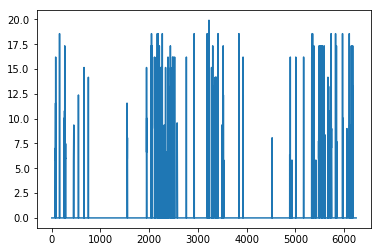

In [12]:
plt.plot(coordination_index)
plt.show()

In [14]:
## compile coordination index info by session
body_part = 'tail_base'
triggered_activity_across_sessions = {}

for session in list(grouped_raw_data.keys()):
    ks_one_sided_less = spatial_coordination_by_session[session]['ks_one_sided_less']
    coord_index = np.nan_to_num([math.log(result, 100)*-1 for result in ks_one_sided_less])

    #put coordination index on time delta dataframe
    coord_index_df = pd.DataFrame(coord_index, columns=['spatial_coordination_index'])
    coord_index_df_time = coord_index_df.set_index(pd.to_timedelta(np.linspace(0, (len(coord_index_df)-1)*(1/5), len(coord_index_df)), unit='s'), drop=True)

    # bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
    binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session][body_part], 80, 20, 1, 2, 3) for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
    binned_velocity_df = binned_velocity_df.transpose()

    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session][body_part].values, crossing_indicies, 80)
    
    coordination_threshold_activity = utils_jjm.average_triggered_regions(coord_index, crossing_indicies, 80)
    
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, coordination_threshold_activity], axis=1, keys=['velocity', 'spatial_coordination'])

#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

In [15]:
combined_by_mouse_timedelta = combined_by_mouse.set_index(pd.to_timedelta(np.linspace(0, (len(combined_by_mouse)-1)*(1/5), len(combined_by_mouse)), unit='s'), drop=True)

In [16]:
resampled_for_plotting = combined_by_mouse_timedelta.resample('.4S').mean()

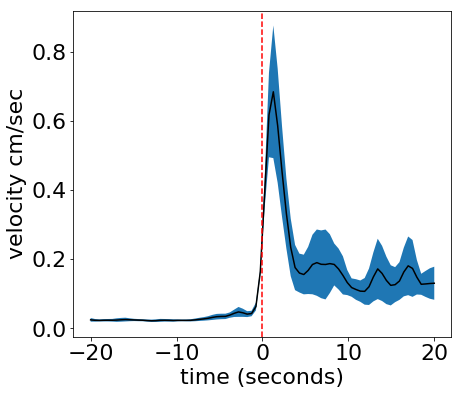

In [31]:
plt.rcParams.update({'font.size': 22})
df_to_plot = resampled_for_plotting
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
scale_f = 0.0868
mean=df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f
plt.plot(x, df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f, color='k')
std_error = ((df_to_plot.std(axis=1, level=2)['velocity'])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]))*scale_f
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('velocity cm/sec')
ax.set_xlabel('time (seconds)')
ax.axvline(x=(0), linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.svg', transparent=True)
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.pdf', transparent=True)
plt.show()

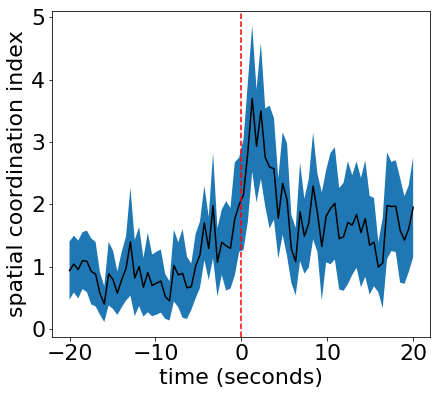

In [32]:
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
mean = df_to_plot.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (df_to_plot.std(axis=1, level=2)[activity_measure])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]*1)
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('spatial coordination index')
ax.set_xlabel('time (seconds)')
ax.axvline(x=0, linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('.svg')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/wt_spatial_coord_spatial_coord_triggered.pdf', transparent=True)
plt.show()

In [38]:
spatial_index_correlations = []
spatial_index_correlations_dict = {}
for session in list(grouped_raw_data.keys()):
    print(session)
    coordination_index = np.nan_to_num([math.log(result, 100)*-1 for result in spatial_coordination_by_session[session]['ks_one_sided_less']])
    velocity = V_df.loc[session]['tail_base'].values[:len(coordination_index)]
    if len(coordination_index)<=len(velocity):
        spatial_index_correlations.append(stats.pearsonr(coordination_index, velocity)[0])
        spatial_index_correlations_dict[session] = stats.pearsonr(coordination_index, velocity)[0]
    else:
        spatial_index_correlations.append(stats.pearsonr(coordination_index[:len(velocity)], velocity)[0])
        spatial_index_correlations_dict[session] = stats.pearsonr(coordination_index[:len(velocity)], velocity)[0]

#concat by mouse 
correlations_concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(spatial_index_correlations_dict.keys())])):
    correlations_by_mouse = []
    sessions = []
    for session in list(spatial_index_correlations_dict.keys()):
        if mouse in session:
            if spatial_index_correlations_dict[session]:
                means = spatial_index_correlations_dict[session]
                correlations_by_mouse.append(means)
                sessions.append(session)
    if len(correlations_by_mouse)>0:
        correlations_concacted_by_mouse[mouse] = np.mean(correlations_by_mouse)

means_by_mouse = [value for value in correlations_concacted_by_mouse.values()]
np.mean(np.array([value for value in correlations_concacted_by_mouse.values()]))

GRIN013_H13_M33_S54
GRIN027_H13_M29_S44
GRIN026_H16_M35_S34
GRIN033_H14_M34_S32
GRIN033_H13_M42_S33
GRIN032_H17_M30_S22
GRIN032_H16_M49_S22
GRIN034_H15_M28_S2
GRIN034_H16_M13_S22
GRIN034_H19_M0_S18
GRIN035_H13_M50_S58
GRIN035_H13_M31_S20
GRIN035_H14_M40_S34


0.10162649920223925

In [41]:
means_by_mouse

[0.13779841050587116,
 0.006747801376127423,
 0.0068303356880426045,
 0.26884191742739066,
 0.10142068142561152,
 0.11391106520465337,
 0.07583528278797806]

In [40]:
ko_means_by_mouse = [0.026046308991659307, 0.0551927415216666, 0.2237641541425582, 0.14667019083698896]

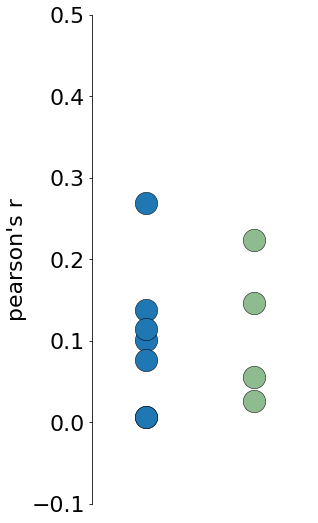

In [65]:
#plt.scatter(np.concatenate([np.zeros(len(means_by_mouse)),np.ones(len(ko_means_by_mouse))/2]), np.concatenate([means_by_mouse, ko_means_by_mouse]),
#           s=200, linewidths=.5, edgecolors='k')
plt.scatter(np.zeros(len(means_by_mouse)), means_by_mouse, s=500, linewidths=.5, edgecolors='k')
plt.scatter(np.ones(len(ko_means_by_mouse))/2, ko_means_by_mouse, s=500, linewidths=.5, edgecolors='k', color='darkseagreen')
plt.xlim([-.25, .75])
plt.ylim([-.1, 0.5])
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.xticks([])
plt.ylabel("pearson's r")
fig = plt.gcf()
fig.set_size_inches(4, 9)
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/wt_spatial_coord_scatterplot.pdf', transparent=True)
plt.show()

In [17]:
active_cell_distances = spatial_coordination_by_session['GRIN013_H13_M33_S54']['active_cell_distances'][74]

In [18]:
cum_results_coactive = stats.cumfreq(active_cell_distances, numbins=binnums, defaultreallimits=(0, 500))
less_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='less')

In [21]:
cum_freq = cum_results_coactive.cumcount/len(active_cell_distances)

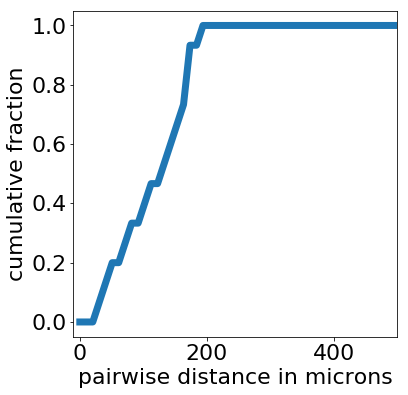

In [25]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(0, 500, len(cum_freq)), cum_freq, linewidth=7.0)
#plt.plot(np.linspace(0, 200, 200), ko_V_data, color='darkseagreen', linewidth=7.0)
plt.xlim((-10, 500))
fig = plt.gcf()
fig.set_size_inches(6, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('pairwise distance in microns')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/spatial_coor_eg.pdf', transparent=True)
plt.show()

In [12]:
spatial_coordination_by_session['GRIN013_H13_M33_S54']

{'ks_one_sided_more': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  0.07233561348940554,
  nan,
  0.07233561348940554,
  0.07233561348940554,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
 